# DQN On Foreign Exchange Market
## Load dataset

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from collections import deque


Flags for the debuging purposes are presented here.

In [3]:
# If this flag is set, each step of the environment's state will be printed
ENVIRONMENT_DEBUG = False

In [4]:
ds = pd.read_csv(
    "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/dqn/USD_TRY%20Gemi%20Verileri.csv"
)
ds["Tarih"] = pd.to_datetime(ds["Tarih"], format='%d/%m/%Y', errors="coerce")
ds["Şimdi"] = pd.to_numeric(ds["Şimdi"].str.replace(",", "."), errors="coerce")
ds["Fark %"] = ds["Fark %"].str.replace("%", "")
ds["Fark %"] = ds["Fark %"].str.replace(",", ".")

ds.head(10)

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Fark %
0,NaT,5.0839,"5,0924","5,1151","5,0612",0.35
1,NaT,5.0660,"4,9924","5,0944","4,9591",1.42
2,NaT,4.9950,"4,9136","5,0183","4,9086",1.64
3,NaT,4.9142,"4,8845","4,9324","4,8734",0.65
4,NaT,4.8823,"4,8459","4,9104","4,8407",0.52
5,NaT,4.8572,"4,8554","4,8584","4,8544",0.09
6,NaT,4.8529,"4,8644","4,8830","4,8340",-0.25
7,NaT,4.8649,"4,7705","4,8845","4,7660",1.93
8,NaT,4.7728,"4,8883","4,8924","4,7728",-2.32
9,NaT,4.8861,"4,7415","4,9403","4,7345",3.09


The reverse version of the data will be used. It is expected to make the learning stronger since from 2002 to this date, usd is increasing with respect to try.

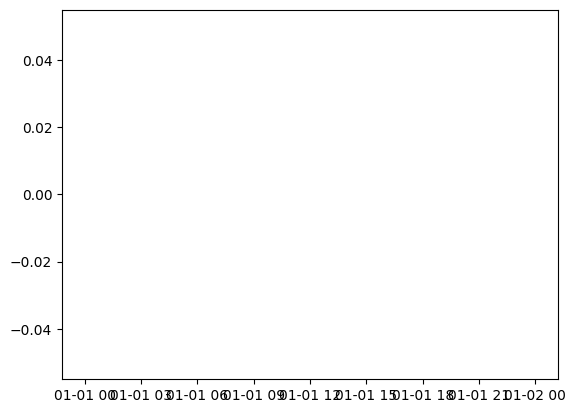

In [5]:
X = ds["Şimdi"]
Y = ds["Tarih"]
X = np.array(X).reshape((len(X), 1))
Y = np.array(Y).reshape((len(Y), 1))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot_date(Y, X, ".")
plt.show()

In [6]:
# Split train and test data

date_split = 4000
train = ds[:date_split]
test = ds[date_split:]
len(train), len(test)

(4000, 207)

## Define envireonment

In [7]:
class Environment:
    def __init__(self, data, tl, history_t=10):
        self.data = data
        self.history_t = history_t
        self.tl_start = tl
        self.reset()

    def reset(self):
        self.tl = self.tl_start
        self.usd = 0
        self.done = False
        self.profits = 0
        self.current_position = "none"
        self.history = [self.data.iloc[x, :]["Fark %"] for x in range(self.history_t)]
        self.t = self.history_t
        self.last_tl = 0
        return self.history

    def step(self, act):
        reward = 0
        if act == 0:  # Hold
            self.current_position = self.current_position
        elif act == 1:  # Buy
            if self.current_position == "none":
                self.current_position = "long"
                # Buy usd

                self.last_tl = self.tl
                self.usd = self.tl / (self.data.iloc[self.t, :]["Şimdi"])
                self.tl = 0
            else:
                self.current_position = self.current_position

        else:  # sell
            if self.current_position == "long":
                self.current_position = "none"
                # Sell usd

                self.tl = self.usd * (self.data.iloc[self.t, :]["Şimdi"])
                self.usd = 0
                self.profits = self.profits + (self.tl - self.last_tl)

                if (self.tl - self.last_tl) > 0:
                    reward = 1
                else:
                    reward = -1
            else:
                self.current_position = self.current_position

        # et next time
        self.t += 1
        # print("history before: ",self.history)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]["Fark %"])
        # print("history after: ",self.history)

        # print("reward: ",reward)

        if ENVIRONMENT_DEBUG == True:
            print(
                "t: ",
                (self.t - self.history_t),
                " reward: ",
                reward,
                " profits: ",
                self.profits,
                " current position: ",
                self.current_position,
                " done: ",
                self.done,
            )

        if self.t == (len(self.data) - 1):
            self.done = True
            print(
                "Total steps: ",
                (self.t - self.history_t),
                " TotalProfit: ",
                self.profits,
                " done: ",
                self.done,
            )

        return self.history, reward, self.done, self.profits  # obs, reward, done

## Agent class

In [8]:
# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size, hidden_layer_size):
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_layer_size = hidden_layer_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(
            Dense(self.hidden_layer_size, input_dim=self.state_size, activation="relu")
        )
        model.add(Dense(self.hidden_layer_size, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = np.array(state).astype(float)
        state = np.reshape(state, [1, self.state_size])
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def act_greedy(self, state):
        state = np.array(state).astype(float)
        state = np.reshape(state, [1, self.state_size])
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(
                    self.model.predict(next_state)[0]
                )
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Train the DQN

In [9]:
if __name__ == "__main__":
    # macros
    EPISODES = 1
    STATE_SIZE = 90

    # profits list
    total_profits = []

    # initialize environment and the agent
    env = Environment(train, 100, STATE_SIZE)  # 100tl, 60 history
    agent = DQNAgent(STATE_SIZE, 3, 100)

    # Iterate the game
    for e in range(EPISODES):
        # check if the buy and sell actions are taken
        actions_count = 0

        # reset state in the beginning of each game
        state = env.reset()
        state = np.reshape(state, [1, STATE_SIZE])

        # time_t represents each frame of the game
        # the more time_t the more score
        for time_t in range(5000):
            # Decide action
            action = agent.act(state)

            if (action == 1) or (action == 2):
                actions_count = actions_count + 1

            # Advance the game to the next frame based on the action.
            next_state, reward, done, profits = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)
            next_state = np.reshape(next_state, [1, STATE_SIZE])

            # make rewards = profits (EXPERIMENTAL)
            reward = profits

            # Remember the previous state, action, reward, and done
            agent.remember(state, action, reward, next_state, done)

            # make next_state the new current state for the next frame.
            state = next_state

            # done becomes True when the game ends
            if done:
                total_profits.append(profits)
                # print the score and break out of the loop
                # print("number of actions taken other than hold in this iteration is ",actions_count,"\n")
                # print("episode: {}/{}, score: {}".format(e, EPISODES, time_t))
                break
        # train the agent with the experience of the episode
        agent.replay(32)


Total steps:  3909  TotalProfit:  -36.91076629230869  done:  True
1/1 [==============================] - 0s 126ms/step

1/1 [==============================] - 0s 234ms/step


In [10]:
def plot_profits(total_profits):
    epoch_count = range(1, len(total_profits) + 1)
    fig = plt.figure(figsize=(30, 10))
    plt.plot(epoch_count, total_profits, "b-")
    plt.legend("Total Profits")
    plt.xlabel("Epoch")
    plt.ylabel("Total Profits")
    plt.figure(figsize=(50, 10))
    plt.show();

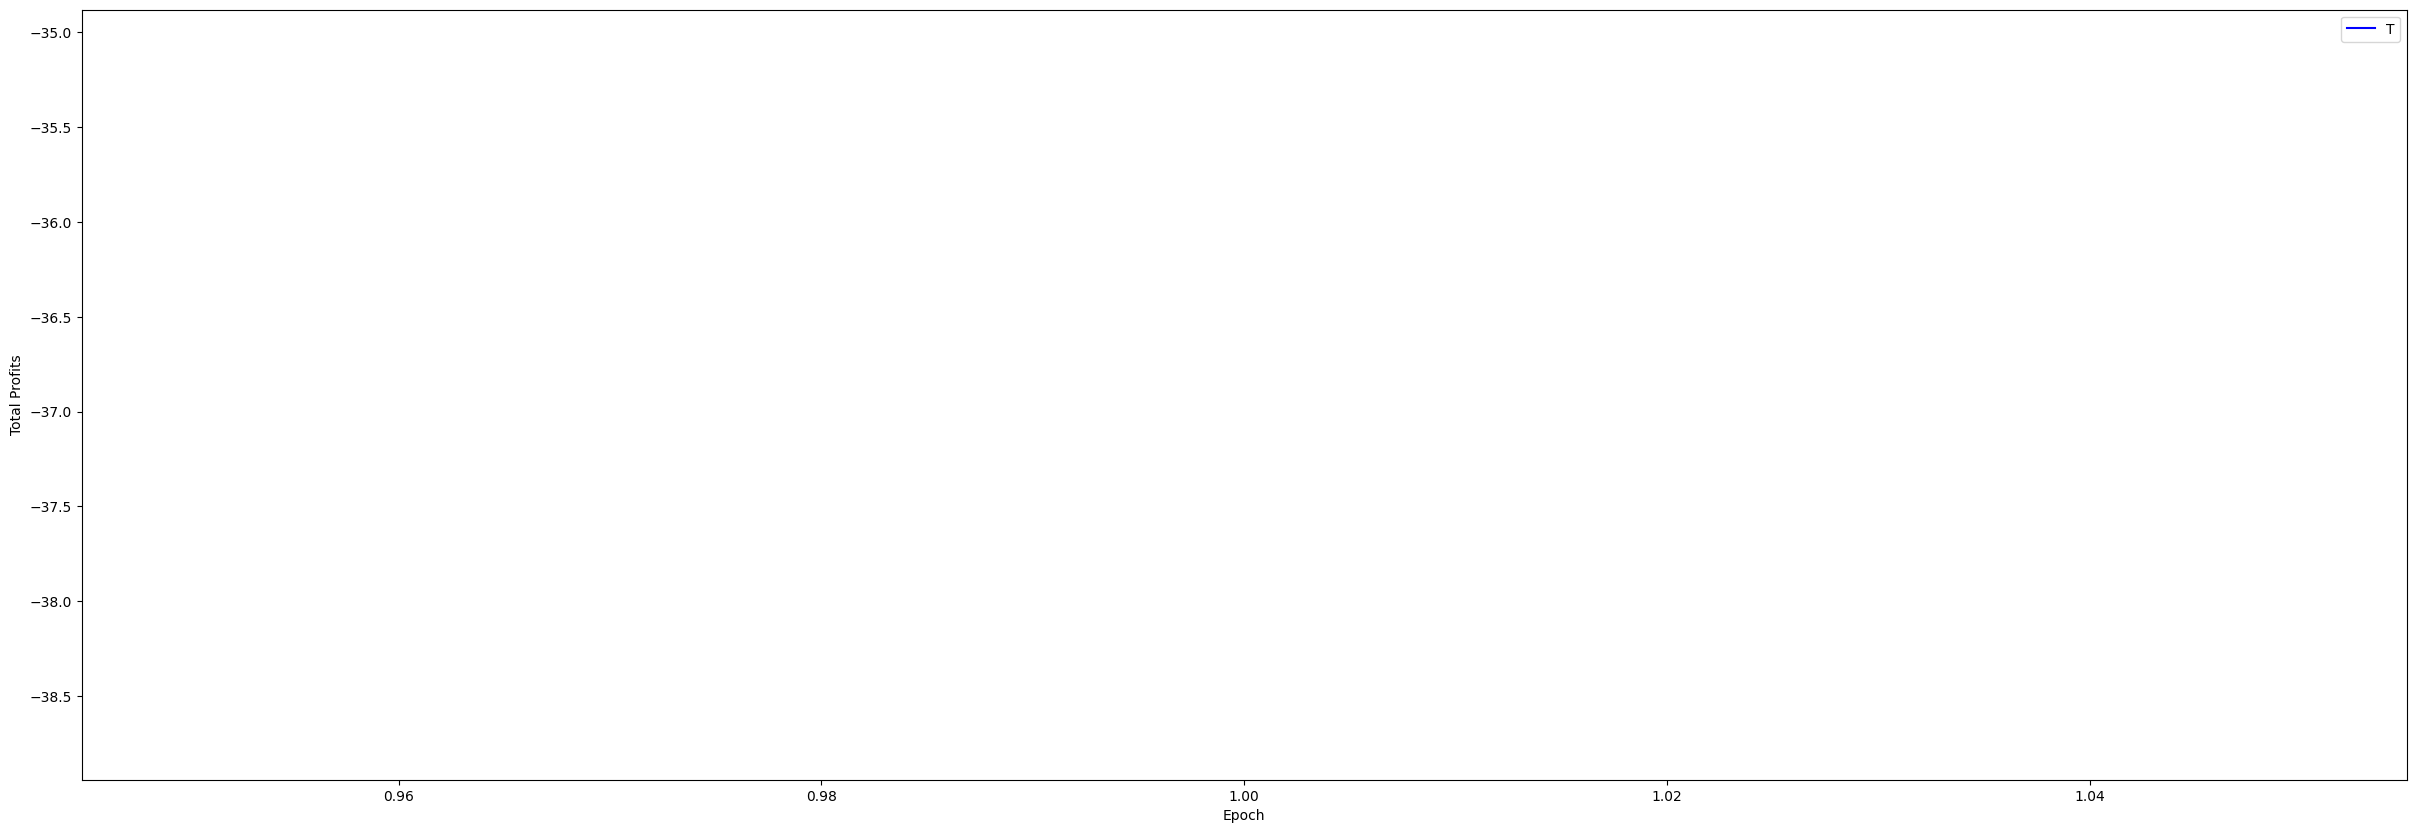

<Figure size 5000x1000 with 0 Axes>

In [11]:
plot_profits(total_profits)

Now test the agent with real world data.

In [12]:
test = test.iloc[::-1]
test.head(10)

,Tarih,Şimdi,Açılış,Yüksek,Düşük,Fark %
4206,NaT,1.6225,"1,6210","1,6725","1,6090",0.06
4205,NaT,1.6245,"1,6150","1,6345","1,6000",0.12
4204,NaT,1.6150,"1,6250","1,6720","1,5850",-0.58
4203,NaT,1.6900,"1,6200","1,6950","1,6200",4.64
4202,NaT,1.6680,"1,6870","1,7110","1,6450",-1.30
4201,NaT,1.6615,"1,6660","1,6695","1,6400",-0.39
4200,NaT,1.6800,"1,6530","1,7100","1,6080",1.11
4199,NaT,1.6660,"1,6700","1,6810","1,6450",-0.83
4198,NaT,1.6780,"1,6590","1,6970","1,6550",0.72
4197,NaT,1.6850,"1,6740","1,7010","1,6600",0.42


In [13]:
env_test = Environment(test, 100, STATE_SIZE)  # 100tl, 60 history

# Iterate the game
for e in range(1):
    # check if the buy and sell actions are taken
    actions_count = 0

    # reset state in the beginning of each game
    state = env_test.reset()
    state = np.reshape(state, [1, STATE_SIZE])

    # time_t represents each frame of the game
    # the more time_t the more score
    for time_t in range(5000):
        # Decide action
        action = agent.act_greedy(state)

        if (action == 1) or (action == 2):
            actions_count = actions_count + 1

        # Advance the game to the next frame based on the action.
        next_state, reward, done, profits = env_test.step(action)

        next_state = np.reshape(next_state, [1, STATE_SIZE])

        # make rewards = profits (EXPERIMENTAL)
        reward = profits

        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)

        # make next_state the new current state for the next frame.
        state = next_state

        # done becomes True when the game ends
        if done:
            break

1/1 [==============================] - 0s 99ms/step
Total steps:  116  TotalProfit:  -0.4191616766467092  done:  True


## Acknowledgement
Thanks to [emrebulbul23](https://www.kaggle.com/emrebulbul23) for creating [DQN on foreign exchange market](https://www.kaggle.com/code/emrebulbul23/dqn-on-foreign-exchange-market). It inspired the majority of the content in this article.